# IEEE-CIS Fraud Detection

Fraud prevention system is protecting our daily transaction and actually saving consumers millions of dollars per year. However, the fraud detection system may be so "sensitive" that places us in an awkward situation. Just imagine standing at the check-out counter at a grocery store with a long line waiting for service and the cashier not-so-quietly announces that your card has been declined. And you step aside and allow the cashier to tend to the next customer. Then you receive a text message from your bank. “Press 1 if you really tried to spend $500 on nachos.”                 
In view of such cumbersome moment, this project is proposed and trying to improve the customer experience as well as fraud detection accuracy. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. 

- **Goal**:         
improve the efficacy of fraudulent transaction

- **Data details**:          
The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.
    - Transaction table: 
        - TransactionID
        - TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
        - TransactionAMT: transaction payment amount in USD
        - ProductCD: product code, the product for each transaction
        - card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
        - addr: address
        - dist: distance
        - P_ and (R__) emaildomain: purchaser and recipient email domain
        - C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
        - D1-D15: timedelta, such as days between previous transaction, etc.
        - M1-M9: match, such as names on card and address, etc.
    - Identity table:
        - TransactionID
        - id_1-id_38: identity information including network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
        - DeviceType
        - DeviceInfo 

## Import

In [1]:
import pandas as pd
import numpy as np
import gc

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
sns.set_style('whitegrid')
%matplotlib inline

## Load Data and Overview

In [3]:
train_identity = pd.read_csv('./Data/train_identity.csv')
train_trans = pd.read_csv('./Data/train_transaction.csv')
test_identity = pd.read_csv('./Data/test_identity.csv')
test_trans = pd.read_csv('./Data/test_transaction.csv')

### Check TransactionID in identity and transaction  

In [4]:
print('Train')
print('Number of TransactionID is train_identity: ', train_identity.shape[0])
print('Number of TransactionID is train_transaction: ', train_trans.shape[0])
print('Number of TransactionID in train have an associated train_identity: ', 
      train_trans.TransactionID.isin(train_identity.TransactionID).sum())
print('Ratio of TransactionID in train have an associated train_identity: {:.2f}%'.format(
    train_trans.TransactionID.isin(train_identity.TransactionID).mean()*100))
print('Test')
print('Number of TransactionID is test_identity: ', test_identity.shape[0])
print('Number of TransactionID is test_transaction: ', test_trans.shape[0])
print('Number of TransactionID in test have an associated test_identity: ', 
      test_trans.TransactionID.isin(test_identity.TransactionID).sum())
print('Ratio of TransactionID in test have an associated test_identity: {:.2f}%'.format(
    test_trans.TransactionID.isin(test_identity.TransactionID).mean()*100))

Train
Number of TransactionID is train_identity:  144233
Number of TransactionID is train_transaction:  590540
Number of TransactionID in train have an associated train_identity:  144233
Ratio of TransactionID in train have an associated train_identity: 24.42%
Test
Number of TransactionID is test_identity:  141907
Number of TransactionID is test_transaction:  506691
Number of TransactionID in test have an associated test_identity:  141907
Ratio of TransactionID in test have an associated test_identity: 28.01%


In [5]:
train = pd.merge(train_trans, train_identity, on='TransactionID', how='left')
test = pd.merge(test_trans, test_identity, on='TransactionID', how='left')

In [7]:
%%capture
col_name = test.columns.tolist()
col_name.insert(col_name.index('TransactionDT'),'isFraud')
test.reindex(columns=col_name)

In [8]:
train['is_train'] = 1
test['is_train'] = 0
test['isFraud'] = ''

In [9]:
df = pd.concat([train, test], ignore_index=True, sort=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097231 entries, 0 to 1097230
Columns: 435 entries, TransactionID to is_train
dtypes: float64(399), int64(4), object(32)
memory usage: 3.6+ GB


In [11]:
del train_identity, train_trans, test_identity, test_trans; gc.collect()

73

### Data overview

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.6+ GB


In [13]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [14]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check missing data

In [17]:
train.isna().apply(lambda x: x.value_counts(), axis=0)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
False,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,581607,588975,588963,586281,...,140282,77586,73289,77805,140985,140985,140985,140985,140810,118666
True,NaN,NaN,NaN,NaN,NaN,NaN,8933,1565,1577,4259,...,450258,512954,517251,512735,449555,449555,449555,449555,449730,471874


In [19]:
test.isna().apply(lambda x: x.value_counts(), axis=0)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
False,506691.0,506691.0,506691.0,506691.0,506691.0,498037,503689,503605,502144,503684,...,136625,70671,70671,72175,136977,136977,136977,136977,136931,115057
True,NaN,NaN,NaN,NaN,NaN,8654,3002,3086,4547,3007,...,370066,436020,436020,434516,369714,369714,369714,369714,369760,391634


In [28]:
print('Missing columns in train: ', train.isnull().any().sum())
print('Missing columns in test: ', test.isnull().any().sum())

Missing columns in train:  414
Missing columns in test:  385


Most of the columns in train and test have missing records. Need to deal with carefully.

### Features

Most of the features in our data are continuous. And the categorical Features are as follows:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain 
- Remaildomain
- M1 - M9
- DeviceType
- DeviceInfo
- id12 - id38

## Exploratory Data Analysis

In [12]:
def groupby_cnt_ratio(df, col):
    if isinstance(col, str):
        col = [col]
    key = ['is_train', 'isFraud'] + col
    cnt_stat = df.groupby(key).size().to_frame('count')
    ratio_stat = (cnt_stat / cnt_stat.groupby(['is_train', 'isFraud']).sum()).rename(columns={'count':'count_ratio'})
    return pd.merge(cnt_stat, ratio_stat, on=key, how='outer')

In [13]:
def barh_plot_all(col, size, n):
    plt.tight_layout()
    fig, axes = plt.subplots(2, 1, figsize=size)
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
    df[col].value_counts().sort_values().tail(n).plot(
        kind='barh', color=sns.color_palette("coolwarm"), ax=ax1)
    train[col].value_counts().sort_values().tail(n).plot(
        kind='barh', color=sns.color_palette("coolwarm"), ax=ax2)
    test[col].value_counts().sort_values().tail(n).plot(
        kind='barh', color=sns.color_palette("coolwarm"), ax=ax3)

    ax1.set_title('Distribution of ' + str(col) + ': all data')
    ax2.set_title('Distribution of ' + str(col) + ': train')
    ax3.set_title('Distribution of ' + str(col) + ': test')
    ax3.yaxis.tick_right()

In [14]:
def barh_plot_isFraud(col, size, n):
    plt.tight_layout()
    fig, axes = plt.subplots(2, 1, figsize=size)
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
    train[col].value_counts().sort_values().tail(n).plot(
        kind='barh', color=sns.color_palette("coolwarm"), ax=ax1)
    train[train['isFraud'] == 1][col].value_counts().sort_values().tail(n).plot(
        kind='barh', color=sns.color_palette("coolwarm"), ax=ax2)
    train[train['isFraud'] == 0][col].value_counts().sort_values().tail(n).plot(
        kind='barh', color=sns.color_palette("coolwarm"), ax=ax3)

    ax1.set_title('Distribution of ' + str(col) + ': train')
    ax2.set_title('Distribution of ' + str(col) + ': fraud')
    ax3.set_title('Distribution of ' + str(col) + ': not fraud')
    ax3.yaxis.tick_right()

In [15]:
def count_plot_all(col):
    fig, axes = plt.subplots(2, 1, figsize=(12,6))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
    sns.countplot(df[col], palette='coolwarm', ax=ax1, order=df[col].value_counts().index.to_list())
    sns.countplot(train[col], palette='coolwarm', ax=ax2, order=df[col].value_counts().index.to_list())
    sns.countplot(test[col], palette='coolwarm', ax=ax3, order=df[col].value_counts().index.to_list())

    ax1.set_title('Distribution of ' + str(col) +': all data')
    ax2.set_title('Distribution of ' + str(col) +': train')
    ax3.set_title('Distribution of ' + str(col) +': test')
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax3.set_xlabel('')

In [16]:
def count_plot_isFraud(col):
    fig, axes = plt.subplots(2, 1, figsize=(12,6))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
    sns.countplot(train[col], palette='coolwarm', ax=ax1, order=train[col].value_counts().index.to_list())
    sns.countplot(train[train['isFraud'] == 1][col], palette='coolwarm', ax=ax2, order=train[col].value_counts().index.to_list())
    sns.countplot(train[train['isFraud'] == 0][col], palette='coolwarm', order=train[col].value_counts().index.to_list())

    ax1.set_title('Distribution of ' + str(col) +': train')
    ax2.set_title('Distribution of ' + str(col) +': fraud')
    ax3.set_title('Distribution of ' + str(col) +': not fraud')
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax3.set_xlabel('')

### Train and test

In [26]:
train_count = len(train)
print('Size of train data',train_count)
test_count = len(test)
print('Size of test data',test_count)
print('Ratio of train to test：', train_count/test_count)

Size of train data 590540
Size of test data 506691
Ratio of train to test： 1.1654834998056014


Train and test have similar size.

### isFraud

Text(0.5, 1.0, 'Distribution of isFraud')

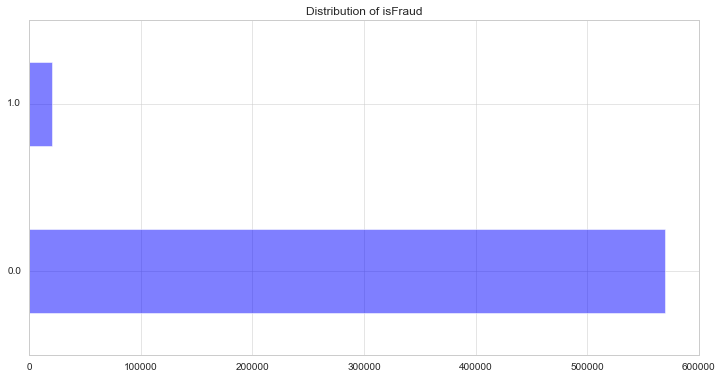

In [72]:
plt.figure(figsize=(12,6))
df['isFraud'].value_counts().plot(kind='barh', alpha=0.5)
plt.title('Distribution of isFraud')

In [81]:
print('Number of fraud transaction in train: ', sum(train['isFraud'] == 1))
print('Number of not fraud transaction in train: ', sum(train['isFraud'] == 0))
print('Ratio of fraud transaction in train: {:.2f}%'.format(sum(train['isFraud'] == 1)/sum(train['isFraud'] == 0)*100))

Number of fraud transaction in train:  20663
Number of not fraud transaction in train:  569877
Ratio of fraud transaction in train: 3.63%


Our data is unbalanced which is typical in the binary classification problems. Only 3.63% transactions are fraud.

### TransactionDT

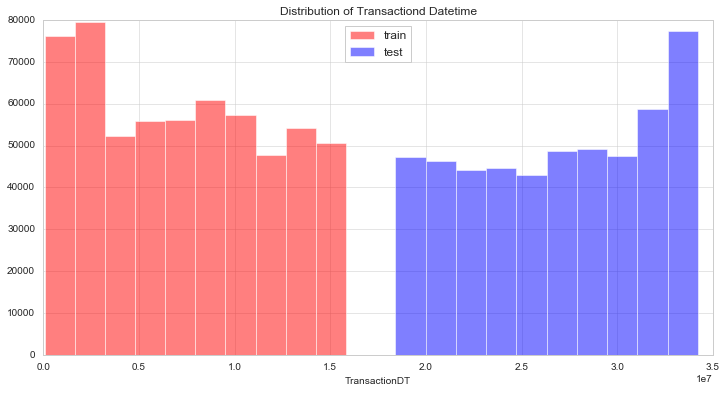

In [73]:
plt.figure(figsize=(12,6))
plt.hist(train['TransactionDT'], label='train', color='red', alpha=0.5)
plt.hist(test['TransactionDT'], label='test', color='blue', alpha=0.5)
plt.title('Distribution of Transactiond Datetime')
plt.xlabel('TransactionDT')
plt.legend(loc='best')

The transaction datetimes for train and test are not overlapping. And they seem to be split by time where train data is from a earlier datatime while test data is from later time. Anf there's a gap in time between train and test. Therefore cross validation method should be carefully used considering this situation.

### Categorical features

#### ProductCD

In [139]:
groupby_cnt_ratio(df, 'ProductCD')

count  count_ratio
is_train isFraud ProductCD                     
0                C           69266     0.136703
                 H           29373     0.057970
                 R           35647     0.070353
                 S           11418     0.022534
                 W          360987     0.712440
1        0       C           60511     0.106183
                 H           31450     0.055187
                 R           36273     0.063651
                 S           10942     0.019201
                 W          430701     0.755779
         1       C            8008     0.387553
                 H            1574     0.076175
                 R            1426     0.069012
                 S             686     0.033199
                 W            8969     0.434061

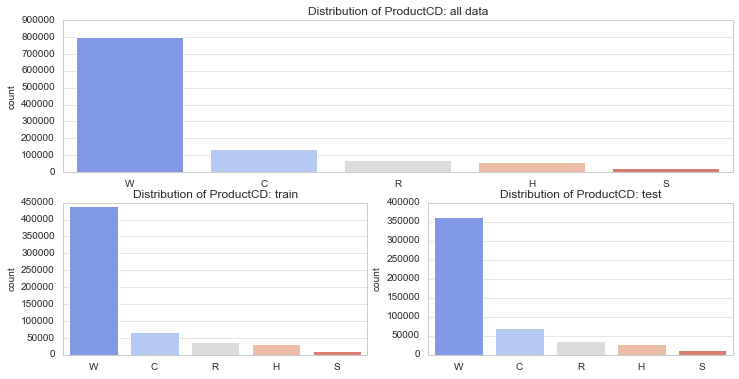

In [100]:
count_plot_all('ProductCD')

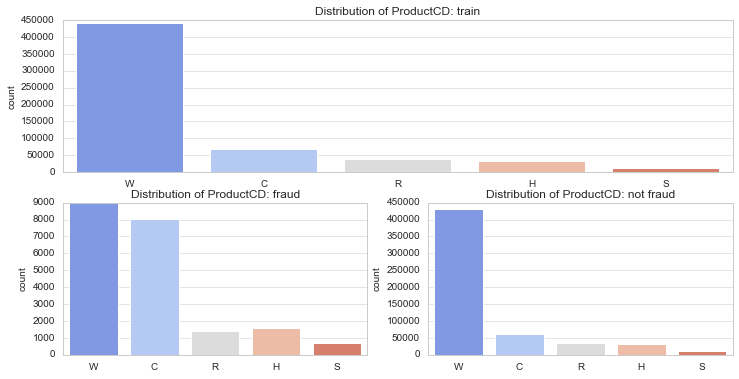

In [102]:
count_plot_isFraud('ProductCD')

- In fradulent transactions, product c takes a larger part. 

#### card4

In [140]:
groupby_cnt_ratio(df, 'card4')

count  count_ratio
is_train isFraud card4                                
0                american express    7681     0.015252
                 discover            2873     0.005705
                 mastercard        158169     0.314074
                 visa              334882     0.664970
1        0       american express    8089     0.014233
                 discover            6137     0.010798
                 mastercard        182721     0.321499
                 visa              371394     0.653470
         1       american express     239     0.011590
                 discover             514     0.024925
                 mastercard          6496     0.315003
                 visa               13373     0.648482

In [29]:
card4_cnt = groupby_cnt_ratio(df, 'card4').reset_index()

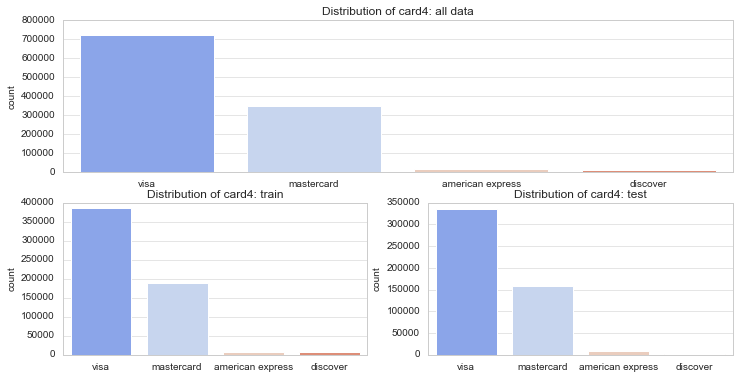

In [103]:
count_plot_all('card4')

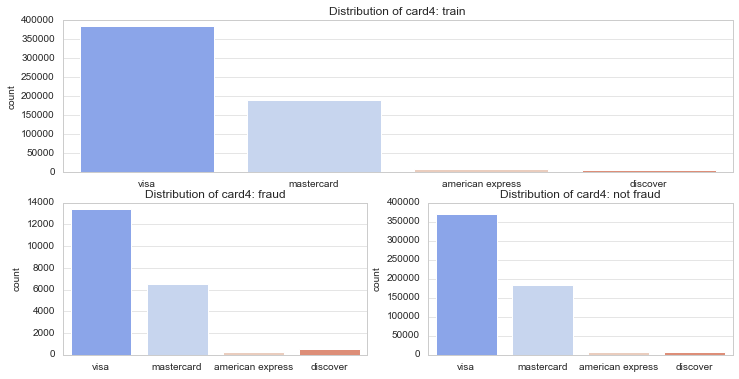

In [18]:
count_plot_isFraud('card4')

In [50]:
def text_style_func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%({:d})".format(pct, absolute)

def pie_param(ax, df, color_palette):
    return ax.pie(df['count_ratio'].values, autopct=lambda pct: text_style_func(pct, df['count']), 
                  labels = df['card4'], explode = [0.1]+ np.zeros(len(df)-1).tolist(), pctdistance = 0.7, 
                  colors=sns.color_palette(color_palette, 4))

In [37]:
card4_cnt_train = card4_cnt[card4_cnt['is_train'] == 1]
card4_cnt_train_fraud = card4_cnt_train[card4_cnt_train['isFraud'] == 1]
card4_cnt_train_not_fraud = card4_cnt_train[card4_cnt_train['isFraud'] == 0]
card4_cnt_test = card4_cnt[card4_cnt['is_train'] == 0]

([<matplotlib.patches.Wedge at 0x11b0e1c18>,
 [Text(1.1986227163591552, 0.05747681121809431, 'american express'),
  Text(1.092890720860439, 0.12485940996637067, 'discover'),
  Text(0.4808667055674827, 0.989326645490091, 'mastercard'),
  Text(-0.5449131831902249, -0.9555467664041862, 'visa')],
 [Text(0.7990818109061033, 0.038317874145396204, '1.5%(7681)'),
  Text(0.6954759132748247, 0.07945598816041768, '0.6%(2873)'),
  Text(0.30600608536112534, 0.6295715016755123, '31.4%(158169)'),
  Text(-0.3467629347574158, -0.6080752149844821, '66.5%(334881)')])

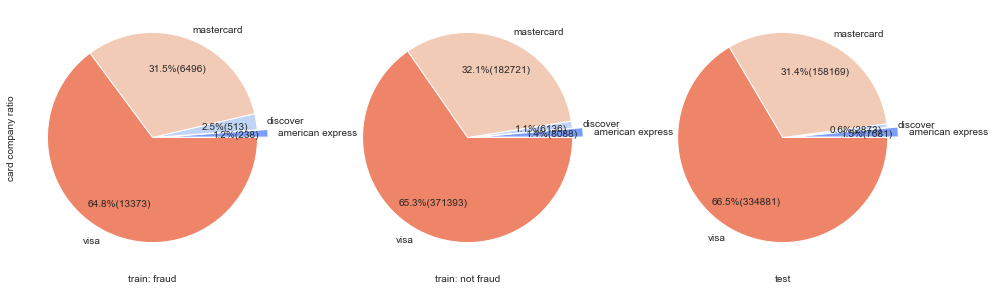

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(16,12))
ax[0].set(xlabel='train: fraud')
ax[0].set(ylabel='card company ratio')
pie_param(ax[0], card4_cnt_train_fraud, "coolwarm")
ax[1].set(xlabel='train: not fraud')
pie_param(ax[1], card4_cnt_train_not_fraud, "coolwarm")
ax[2].set(xlabel='test')
pie_param(ax[2], card4_cnt_test, "coolwarm")

- For both train and test data, visa is the most common card company of transaction. 
- Distributions show little difference. But if we dig into the numbers, we'll get another story. The ratio of discover is more than double in fradulent transactions while ratios for other card companies are lower than the not fraudulent records. 
- Cards of Discover may be at a higher risk of fraud transaction.

#### Pemaildomain & Remaildomain

<Figure size 432x288 with 0 Axes>

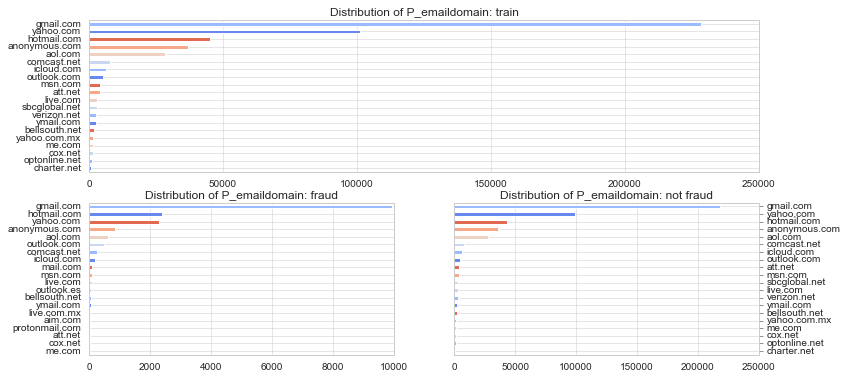

In [164]:
barh_plot_isFraud('P_emaildomain', size=(12,6), n=20)

<Figure size 432x288 with 0 Axes>

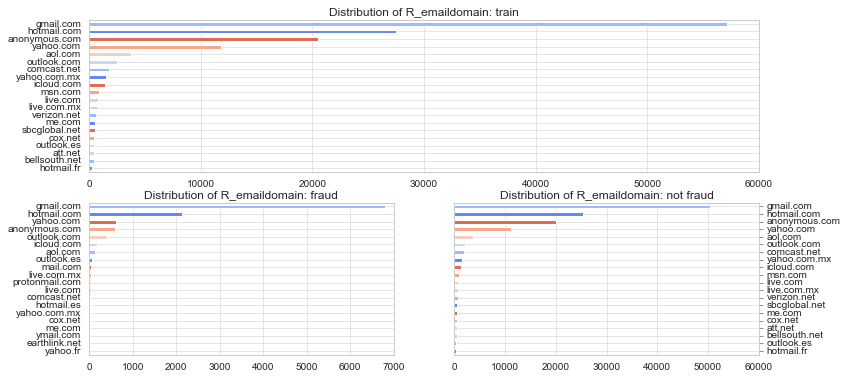

In [165]:
barh_plot_isFraud('R_emaildomain', size=(12,6), n=20)

- Fraudulent purchasers prefer hotmail than yahoo in comparing with not fraud customers.

#### DeviceType

In [112]:
groupby_cnt_ratio(df, 'DeviceType')

count  count_ratio
is_train isFraud DeviceType                    
0                desktop     74403     0.543361
                 mobile      62528     0.456639
1        0       desktop     79611     0.614287
                 mobile      49988     0.385713
         1       desktop      5554     0.495406
                 mobile       5657     0.504594

<Figure size 432x288 with 0 Axes>

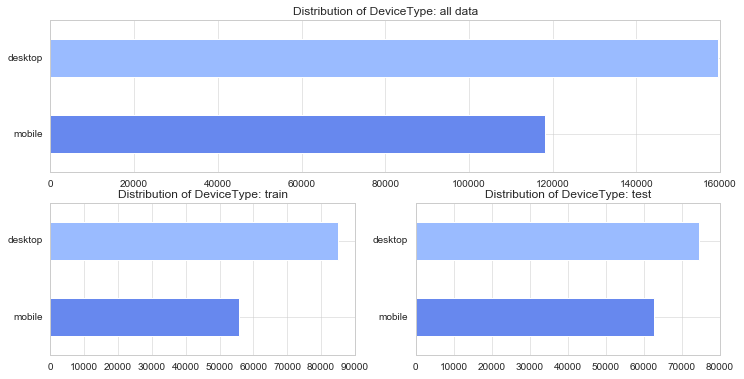

In [126]:
barh_plot_all('DeviceType', size=(12,6))

<Figure size 432x288 with 0 Axes>

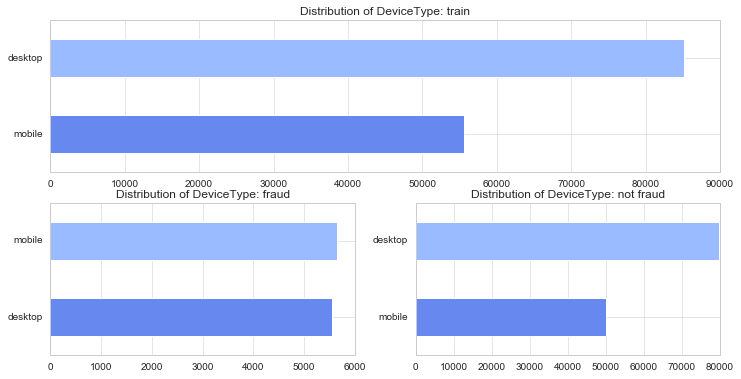

In [127]:
barh_plot_isFraud('DeviceType', size=(12,6))

- Fraudulent transactions are made on mobile more than on desktop.
- Mobile transaction seems to be less secure than desktop.

#### DeviceInfo

In [129]:
df['DeviceInfo'].value_counts()

Windows           92710
iOS Device        38502
MacOS             23722
Trident/7.0       12330
rv:11.0            2650
                  ...  
SM-T827R4             1
GT-N8013              1
rv:60.1.0             1
Orange_Rise_33        1
TR10RS1               1
Name: DeviceInfo, Length: 2799, dtype: int64

<Figure size 432x288 with 0 Axes>

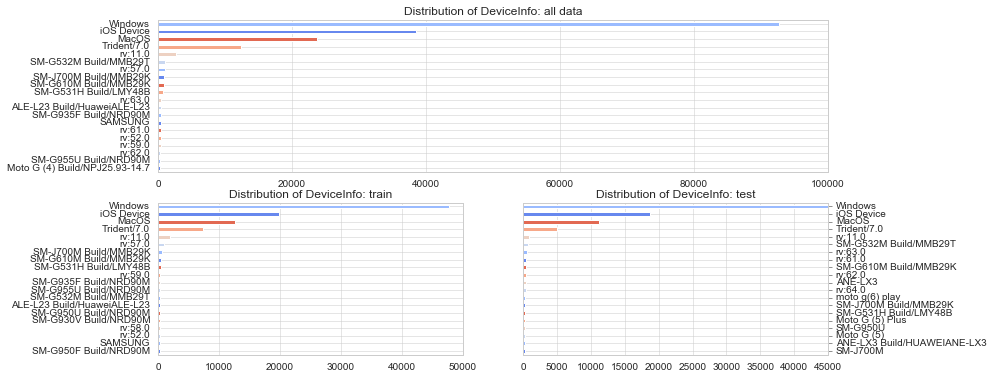

In [166]:
barh_plot_all('DeviceInfo', size=(12,6), n=20)

<Figure size 432x288 with 0 Axes>

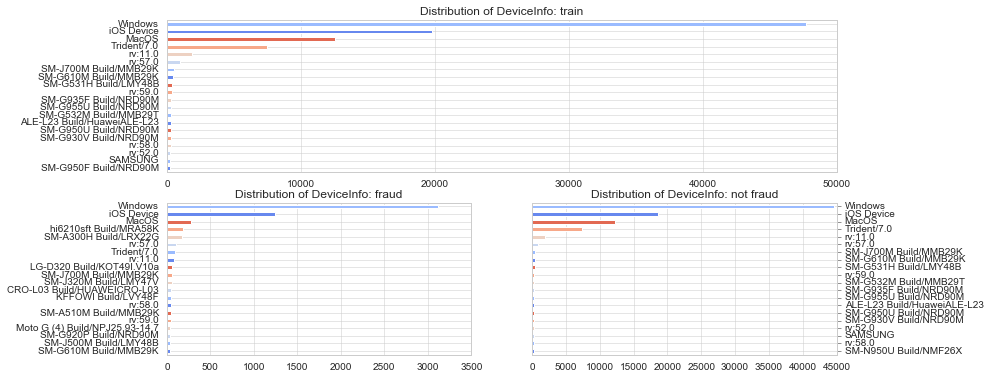

In [168]:
barh_plot_isFraud('DeviceInfo', size=(12,6), n=20)

In [17]:
plt.savefig('./Fig/DeviceInfo.png')

<Figure size 432x288 with 0 Axes>

In [171]:
train[train['isFraud'] == 1]['DeviceInfo'].value_counts().head(20)

Windows                           3121
iOS Device                        1240
MacOS                              278
hi6210sft Build/MRA58K             180
SM-A300H Build/LRX22G              169
rv:57.0                            103
Trident/7.0                         96
rv:11.0                             76
LG-D320 Build/KOT49I.V10a           61
SM-J700M Build/MMB29K               60
SM-J320M Build/LMY47V               57
KFFOWI Build/LVY48F                 51
CRO-L03 Build/HUAWEICRO-L03         51
rv:58.0                             49
SM-A510M Build/MMB29K               45
rv:59.0                             44
Moto G (4) Build/NPJ25.93-14.7      40
SM-G920P Build/NRD90M               39
SM-J500M Build/LMY48B               39
SM-G610M Build/MMB29K               37
Name: DeviceInfo, dtype: int64

- Despite for the top 3 device which is prevalent among all groups, hi6210sft Build/MRA58K and SM-A300H Build/LRX22G seem to be abnormal. They rank pretty high in fraud transaction records while they even don't appear in the non-fraud group's ranking. 
- Device info may be a good inference for fraud detection.

### Contnuous features
#### TransactionAMT

In [59]:
df.groupby('is_train')['TransactionAmt'].agg(['max','min', 'mean','median', 'std'])

,max,min,mean,median,std
is_train,,,,,
0,10270.000,0.018,134.725568,67.950,245.779822
1,31937.391,0.251,135.027176,68.769,239.162522


In [109]:
df.groupby('isFraud')['TransactionAmt'].agg(['max','min', 'mean', 'median', 'std'])

,max,min,mean,median,std
isFraud,,,,,
0.0,31937.391,0.251,134.511665,68.5,239.395078
1.0,5191.000,0.292,149.244779,75.0,232.212163


Since the variance of amount distribution is large, apply log transformation to get rid of the affect extreme transaction amount.

Text(0.5, 0, 'TransactionAmt')

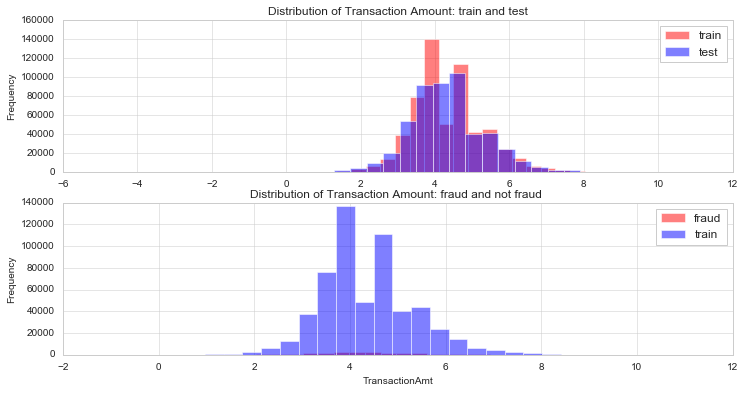

In [99]:
fig, axes = plt.subplots(2, 1, figsize=(12,6))
train['TransactionAmt'].apply(np.log).plot(kind='hist', label='train', color='red', 
                                           alpha=0.5, bins=30, ax=axes[0])
test['TransactionAmt'].apply(np.log).plot(kind='hist', label='test', color='blue', 
                                           alpha=0.5, bins=30, ax=axes[0])
train[train['isFraud'] == 1]['TransactionAmt'].apply(np.log).plot(kind='hist', label='fraud', color='red', 
                                           alpha=0.5, bins=30, ax=axes[1])
train[train['isFraud'] == 0]['TransactionAmt'].apply(np.log).plot(kind='hist', label='train', color='blue', 
                                           alpha=0.5, bins=30, ax=axes[1])
axes[0].legend()
axes[0].set_title('Distribution of Transaction Amount: train and test')
axes[1].legend()
axes[1].set_title('Distribution of Transaction Amount: fraud and not fraud ')
axes[1].set_xlabel('TransactionAmt')

Take a closer look at the amount distribution of fraud and not fraud.

Text(0.5, 1.0, 'Distribution of Transaction Amount: not fraud')

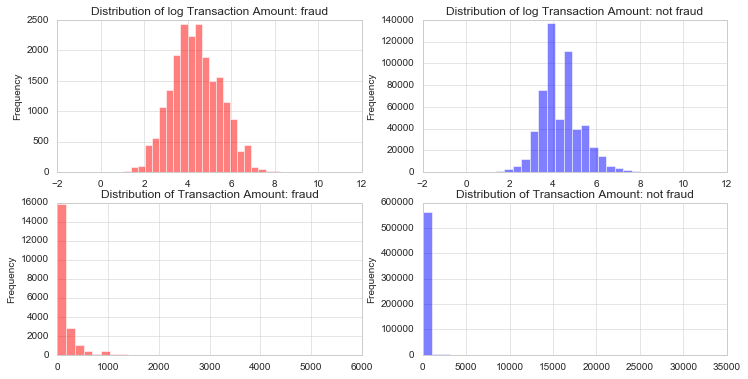

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
train[train['isFraud'] == 1]['TransactionAmt'].apply(np.log).plot(kind='hist', label='fraud', color='red', 
                                           alpha=0.5, bins=30, ax=axes[0,0], xlim=(-2,12))
train[train['isFraud'] == 0]['TransactionAmt'].apply(np.log).plot(kind='hist', label='train', color='blue', 
                                           alpha=0.5, bins=30, ax=axes[0,1])
train[train['isFraud'] == 1]['TransactionAmt'].plot(kind='hist', label='fraud', color='red', 
                                           alpha=0.5, bins=30, ax=axes[1,0])
train[train['isFraud'] == 0]['TransactionAmt'].plot(kind='hist', label='train', color='blue', 
                                           alpha=0.5, bins=30, ax=axes[1,1])

axes[0,0].set_title('Distribution of log Transaction Amount: fraud')
axes[0,1].set_title('Distribution of log Transaction Amount: not fraud')
axes[1,0].set_title('Distribution of Transaction Amount: fraud')
axes[1,1].set_title('Distribution of Transaction Amount: not fraud')

- The distributions of *TransactionAmt* for train and test are similar except the maxminum in test is much larger.
- Fraudulent charges appear to have more higher amount transaction.

In [172]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,is_train
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,1
